In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.transforms import Compose, ToTensor
from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
import random
import math
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

# Loading data

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.load_audio_files(self.data_dir)
        
    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:

                file_path = os.path.join(dirname, filename)
                label = dirname.split('/')[-1]
                label = torch.tensor([ord(label) - ord('a')])
                

                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

In [3]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=1024+512, win_length=1024, f_min = 100, f_max=2500)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('/kaggle/input/keyboard-sounds', transforms)

Wrong shape: torch.Size([1, 64, 31])
Wrong shape: torch.Size([1, 64, 33])
Wrong shape: torch.Size([1, 64, 25])


In [4]:
train_size = 30 * 26 - 1 # 3 files were malformed
val_size = 10 * 26 - 1
test_size = 10 * 26 - 1
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data augmentation setup

In [5]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [6]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [7]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])
train_set = TrainingDataset(train_set, aug_transforms)
val_set = TrainingDataset(val_set, transforms)
test_set = TrainingDataset(test_set, transforms)

## Training set image (augmented)

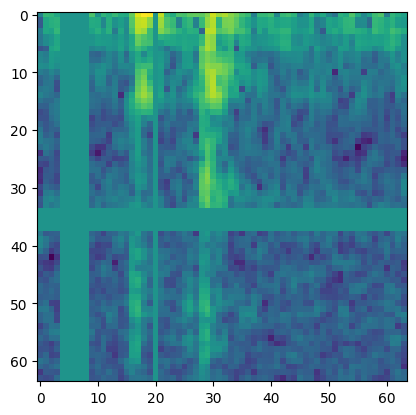

In [8]:
plt.imshow(train_set[0][0][0], cmap='viridis')

## Validation set image (not augmented)

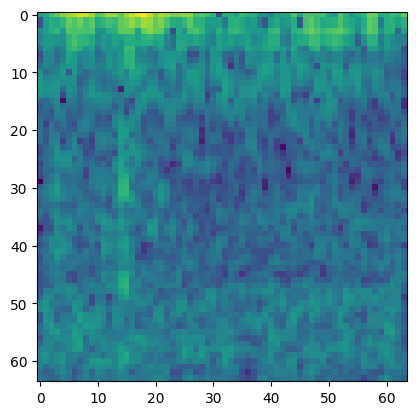

In [9]:
plt.imshow(transforms(dataset[2][0])[0], cmap='viridis')

# CoAtNet

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2)
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size))
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=26):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 6, 14, 2]           # L
channels = [64, 96, 192, 384, 768]      # D
model = MyCoAtNet(nums_blocks, channels)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
!pip install torchsummary

In [22]:
# Taken from MyCoAtNet
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Taken from MyCoAtNet
model.apply(init_linear)
model.to(device);
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
from torchinfo import summary
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

Number of parameters: 41,808,178
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

# Training

In [24]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [26]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [27]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1650
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [28]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [29]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [30]:
best_model_path = "/kaggle/working/CoAtNet-1-Best.pkl"
model_path = "/kaggle/working/CoAtNet-1.pkl"
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

Epoch [1/1650], Loss: 22.546581268310547, Accuracy: 0.059050064184852376 Correct: 46 Total: 779 LR: 0.0005 -> 0.0004996975757575758
Validation Accuracy: 0.08108108108108109 Validation loss: 16.48102378845215 Correct: 21 Total: 259
Epoch [2/1650], Loss: 16.6713924407959, Accuracy: 0.09242618741976893 Correct: 72 Total: 779 LR: 0.0004996975757575758 -> 0.0004993951515151516
Validation Accuracy: 0.03861003861003861 Validation loss: 35.40837478637695 Correct: 10 Total: 259
Epoch [3/1650], Loss: 7.151835918426514, Accuracy: 0.110397946084724 Correct: 86 Total: 779 LR: 0.0004993951515151516 -> 0.0004990927272727273
Validation Accuracy: 0.13127413127413126 Validation loss: 11.849995613098145 Correct: 34 Total: 259
Epoch [4/1650], Loss: 11.937564849853516, Accuracy: 0.1681643132220796 Correct: 131 Total: 779 LR: 0.0004990927272727273 -> 0.000498790303030303
Validation Accuracy: 0.27413127413127414 Validation loss: 6.483100414276123 Correct: 71 Total: 259


KeyboardInterrupt: 

In [ ]:
save_model(model, model_path)

# Results

In [31]:
best_model_path = "/kaggle/input/keyboard-coatnet-1/pytorch/coatnet-1/1/CoAtNet-1-Best.pkl"
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [32]:
print("Best validation acc: ", max(val_accuracies))

Best validation acc:  0.27413127413127414


In [33]:
print("Last validation acc: ", val_accuracies[-1])

Last validation acc:  0.27413127413127414


In [34]:
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]
label_dict = {}
for i in range(ord('Z') - ord('A') + 1):
    label_dict[i] = alphabet[i]
print(label_dict)
len(alphabet)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


26

In [35]:
# Adapted from My_CoAtNet
predictions_path = '/kaggle/working/predictions.csv'
def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:
        character_lab = []
        character_pred = []
        
        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

## Test accuracy

In [36]:
cm = predict(test_dataloader)

Test Accuracy: 0.9343629343629344


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
predicted_labels,M,V,P,J,P,V,B,Y,C,V,L,V,N,O,O,H,M,K,B,B,Q,D,S,Q,X,W,V,R,K,C,K,M,X,Z,E,O,V,P,X,C,L,M,N,E,R,I,X,A,I,P,X,K,Y,C,O,C,H,L,Q,U,D,B,Y,Z,T,Q,Z,C,G,W,Z,T,Y,T,A,J,I,P,G,D,G,H,B,P,X,G,V,H,Y,G,J,N,A,Y,J,A,L,D,O,A,M,H,A,E,B,S,V,N,A,N,X,B,M,H,O,Y,S,A,Z,T,O,N,Q,N,F,K,T,P,R,I,F,G,T,S,S,K,Z,O,B,W,J,Q,J,P,A,E,Q,I,L,D,I,O,N,W,J,S,S,B,M,U,Q,S,T,U,N,R,A,K,C,L,R,A,X,M,V,V,V,I,E,T,X,U,B,P,U,O,B,W,R,D,Y,G,O,S,G,U,F,S,G,K,Z,B,Q,T,I,S,G,O,X,E,T,F,N,J,C,W,F,Q,K,W,O,R,X,U,U,K,H,C,V,J,P,B,S,O,W,F,Q,W,X,O,F,A,Z,P,N,J,H,W,K,P,Q,R,U,J,E,X,E,K,Y
true_labels,M,V,P,J,P,V,B,Y,V,V,L,V,J,O,O,H,M,K,B,B,Q,D,S,Q,X,W,V,R,K,C,K,M,X,Z,E,O,C,P,X,C,L,M,N,O,R,I,X,A,I,P,X,K,R,C,O,C,G,K,Q,P,D,B,Y,Z,T,Q,Z,C,G,W,Z,T,Y,T,A,J,I,P,G,D,G,H,B,P,X,G,V,H,Y,G,J,N,A,Y,J,A,L,D,O,A,M,H,A,E,J,S,V,N,A,N,X,B,M,H,O,Y,S,A,Z,D,O,N,Q,N,F,K,T,O,R,I,F,G,T,S,S,K,Z,O,B,W,J,Q,J,P,A,E,Q,I,L,D,I,O,N,W,J,S,S,B,M,U,Q,S,T,U,N,R,A,K,C,L,R,A,X,M,V,V,V,I,E,T,X,U,B,P,U,O,B,W,R,D,Y,G,U,S,G,U,F,S,G,K,Z,B,Q,T,I,S,G,O,X,E,T,F,N,J,C,W,F,Q,K,W,O,R,X,U,U,K,H,C,C,J,P,H,S,P,W,F,Q,W,Z,O,F,A,Z,P,N,K,H,W,K,P,Q,R,U,J,E,X,E,K,Y


0.9343629343629344
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.85      1.00      0.92        11
           2       0.89      0.80      0.84        10
           3       1.00      0.86      0.92         7
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00         7
           6       1.00      0.91      0.95        11
           7       0.88      0.88      0.88         8
           8       1.00      1.00      1.00         8
           9       0.91      0.83      0.87        12
          10       1.00      0.86      0.92        14
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         8
          13       0.91      1.00      0.95        10
          14       0.87      0.87      0.87        15
          15       0.92      0.85      0.88        13
          16       1.00      1.00      1.00        12
        

## Confusion matrix

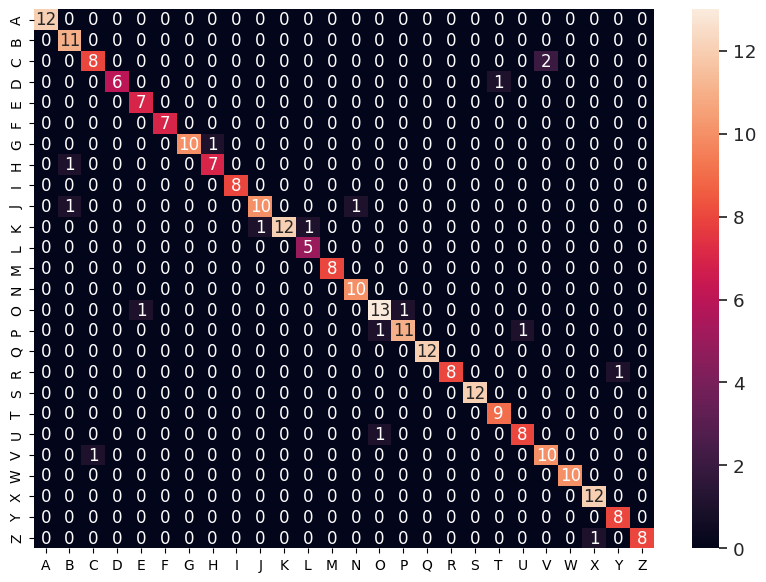

In [37]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")

# Acknowledgements
I have found these resources useful while writing this notebook:
1. [anastasiialobanova's My_CoAtNet Kaggle notebook](https://www.kaggle.com/code/anastasiialobanova/my-coatnet)
2. [xmu-xiaoma666's implementation of CoAtNet](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
3. [https://m0nads.wordpress.com/tag/self-attention/](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
4. [chinhsuanwu's implementation of CoAtNet](https://github.com/chinhsuanwu/coatnet-pytorch/blob/master/coatnet.py)